## 1. Setup and Imports

In [1]:
import os
import sys
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import yaml
from tqdm import tqdm

# YOLO
from ultralytics import YOLO

# Set project root
PROJECT_ROOT = Path(r"c:/Users/anike/Downloads/WasteSegregation")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project Root: {PROJECT_ROOT}")
print("✅ Imports successful!")

Project Root: c:\Users\anike\Downloads\WasteSegregation
✅ Imports successful!


In [ ]:
# 🔍 GPU CHECK - Run this cell to verify GPU access
import torch

print("=" * 50)
print("🖥️ HARDWARE CHECK")
print("=" * 50)

# Check PyTorch/CUDA (used by YOLO)
print("\n📦 PyTorch CUDA Status:")
print(f"   PyTorch Version: {torch.__version__}")
print(f"   CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"   ✅ NVIDIA GPU Detected!")
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Count: {torch.cuda.device_count()}")
    print(f"   CUDA Version: {torch.version.cuda}")
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"   GPU Memory: {gpu_mem:.1f} GB")
    print("\n🚀 You're ready for fast GPU training!")
    DEVICE = "cuda"
else:
    print("   ❌ No NVIDIA GPU detected")
    print("\n💻 Training will use CPU")
    print("   Your system has an Intel GPU which doesn't support CUDA.")
    print("\n⏱️ ESTIMATED TRAINING TIME (CPU):")
    print("   • With optimized settings: ~15-30 minutes")
    print("   • This is acceptable for the current configuration!")
    DEVICE = "cpu"

print("\n" + "=" * 50)
print(f"🎯 Training will use: {DEVICE.upper()}")
print("=" * 50)

🖥️ GPU AVAILABILITY CHECK

📦 PyTorch CUDA Status:
   CUDA Available: False
   ❌ No GPU detected

⚠️ Training will use CPU (slower)
   To enable GPU:
   1. Install CUDA Toolkit
   2. Install PyTorch with CUDA: pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118



In [3]:
# Load configuration
config_path = PROJECT_ROOT / "config" / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Define paths
PROCESSED_DATA_PATH = PROJECT_ROOT / "datasets" / "processed"
MODELS_PATH = PROJECT_ROOT / "models" / "yolo"
OUTPUTS_PATH = PROJECT_ROOT / "outputs"

# YOLO configuration
YOLO_CONFIG = config['yolo']

print("📋 YOLO Training Configuration:")
print("=" * 40)
print(f"   Base Model: {YOLO_CONFIG['model']}")
print(f"   Epochs: {YOLO_CONFIG['epochs']}")
print(f"   Batch Size: {YOLO_CONFIG['batch_size']}")
print(f"   Image Size: {config['dataset']['yolo_image_size']}")
print(f"   Confidence Threshold: {YOLO_CONFIG['confidence_threshold']}")
print(f"   IoU Threshold: {YOLO_CONFIG['iou_threshold']}")

📋 YOLO Training Configuration:
   Base Model: yolov8n.pt
   Epochs: 15
   Batch Size: 8
   Image Size: 320
   Confidence Threshold: 0.5
   IoU Threshold: 0.45


## 2. Verify Dataset Structure

In [4]:
# Verify dataset paths
dataset_yaml_path = PROJECT_ROOT / "config" / "dataset.yaml"

print("📁 Verifying Dataset Structure:\n")

# Check directories
splits = ['train', 'val', 'test']
all_valid = True

for split in splits:
    images_dir = PROCESSED_DATA_PATH / split / "images"
    labels_dir = PROCESSED_DATA_PATH / split / "labels"
    
    images_count = len(list(images_dir.glob("*.jpg"))) if images_dir.exists() else 0
    labels_count = len(list(labels_dir.glob("*.txt"))) if labels_dir.exists() else 0
    
    status = "✅" if images_count > 0 and labels_count > 0 else "❌"
    if images_count == 0 or labels_count == 0:
        all_valid = False
    
    print(f"{status} {split.upper()}:")
    print(f"   Images: {images_count}")
    print(f"   Labels: {labels_count}")

if all_valid:
    print("\n✅ Dataset structure verified!")
else:
    print("\n❌ Dataset structure incomplete. Please run Phase 2 first.")

📁 Verifying Dataset Structure:

✅ TRAIN:
   Images: 1768
   Labels: 1768
✅ VAL:
   Images: 378
   Labels: 378
✅ TEST:
   Images: 381
   Labels: 381

✅ Dataset structure verified!


In [5]:
# Display dataset.yaml configuration
print("📄 Dataset YAML Configuration:")
print("=" * 40)

with open(dataset_yaml_path, 'r') as f:
    dataset_config = yaml.safe_load(f)
    print(yaml.dump(dataset_config, default_flow_style=False))

📄 Dataset YAML Configuration:
names:
- waste
nc: 1
path: c:\Users\anike\Downloads\WasteSegregation\datasets\processed
test: test/images
train: train/images
val: val/images



## 3. Visualize Training Samples

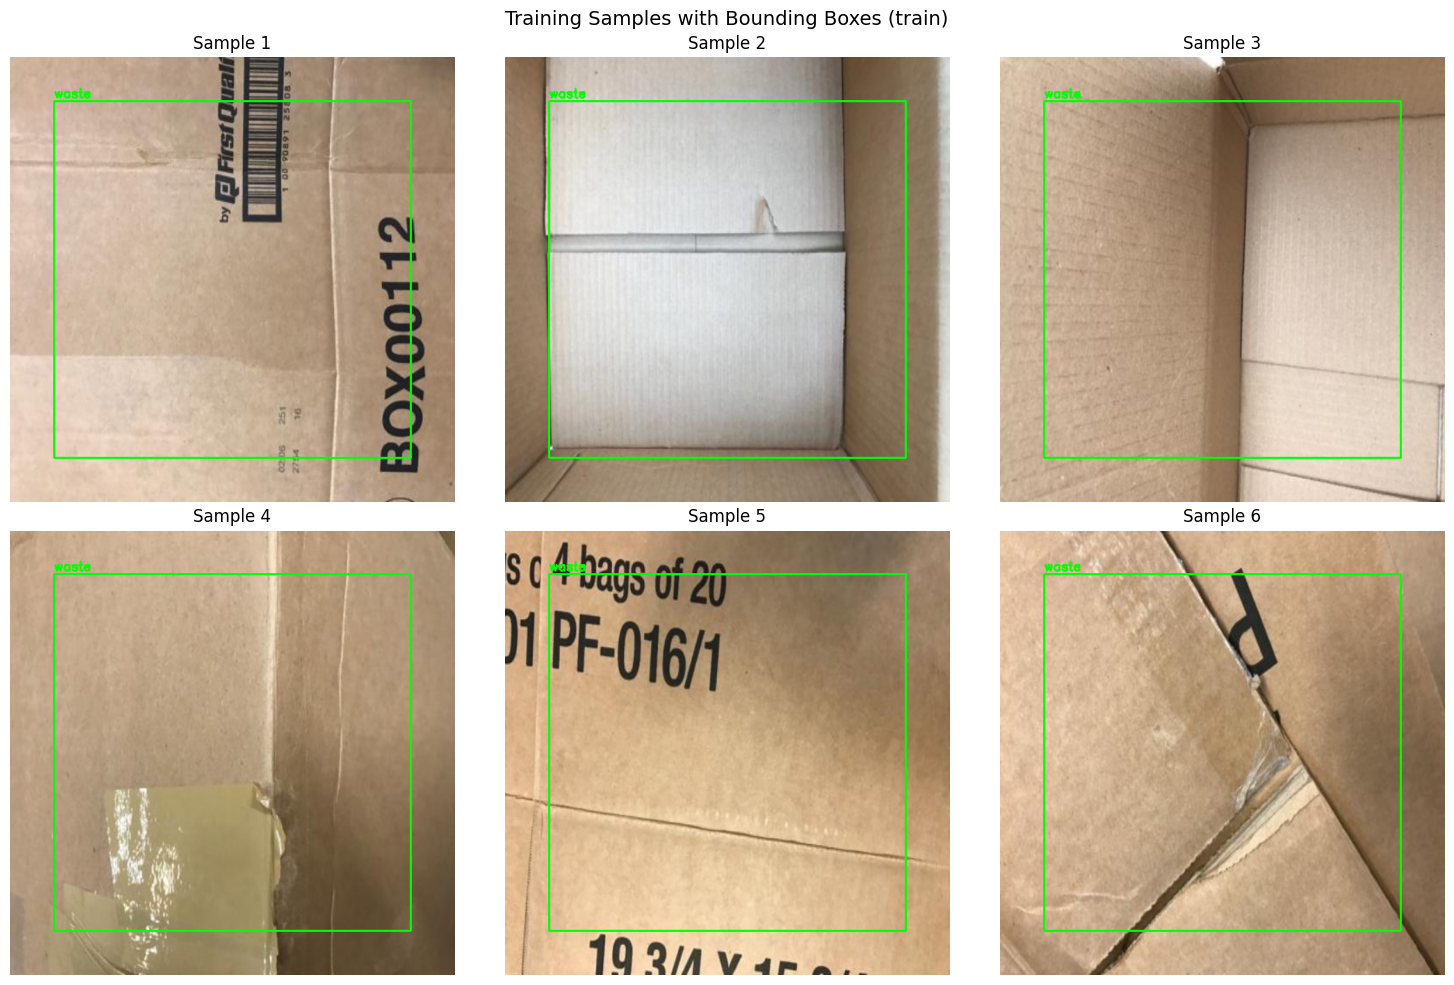

In [6]:
def visualize_yolo_samples(data_path, split='train', num_samples=6):
    """
    Visualize sample images with their YOLO annotations.
    """
    images_dir = data_path / split / "images"
    labels_dir = data_path / split / "labels"
    
    image_files = list(images_dir.glob("*.jpg"))[:num_samples]
    
    rows = 2
    cols = num_samples // 2
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (ax, img_path) in enumerate(zip(axes, image_files)):
        # Load image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Load annotation
        label_path = labels_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls, x_c, y_c, bw, bh = map(float, parts)
                        
                        # Convert normalized coords to pixels
                        x1 = int((x_c - bw/2) * w)
                        y1 = int((y_c - bh/2) * h)
                        x2 = int((x_c + bw/2) * w)
                        y2 = int((y_c + bh/2) * h)
                        
                        # Draw bounding box
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        cv2.putText(img, 'waste', (x1, y1-5), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Sample {idx+1}")
    
    plt.suptitle(f'Training Samples with Bounding Boxes ({split})', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_yolo_samples(PROCESSED_DATA_PATH, 'train', 6)

## 4. Initialize YOLO Model

In [7]:
# Initialize YOLOv8 model
print("🔄 Initializing YOLO model...")

# Use YOLOv8 nano for faster training (can use 's', 'm', 'l', 'x' for larger models)
model_variant = YOLO_CONFIG['model']  # 'yolov8n.pt'

# Load pretrained model
model = YOLO(model_variant)

print(f"\n✅ YOLO model loaded: {model_variant}")
print(f"   Model type: {type(model).__name__}")

🔄 Initializing YOLO model...

✅ YOLO model loaded: yolov8n.pt
   Model type: YOLO


In [8]:
# Display model architecture summary
print("📋 Model Architecture Summary:")
print("=" * 50)
model.info()

📋 Model Architecture Summary:
YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(129, 3157200, 0, 8.8575488)

## 5. Train YOLO Model

⚠️ **Note**: Training may take a while depending on your hardware. GPU is recommended.

In [11]:
# Training configuration - ULTRA FAST FOR CPU
# Reload config to get updated values
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
YOLO_CONFIG = config['yolo']

TRAIN_CONFIG = {
    'data': str(dataset_yaml_path),
    'epochs': 5,    # Minimal epochs for quick training
    'imgsz': 224,   # Smaller image size for speed
    'batch': 16,    # Larger batch = fewer iterations
    'name': 'waste_detector',
    'project': str(MODELS_PATH),
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'SGD',  # SGD is faster than AdamW on CPU
    'verbose': True,
    'seed': 42,
    'deterministic': False,
    'patience': 3,   # Early stopping
    'save': True,
    'save_period': -1,  # Only save best/last
    'val': True,
    'plots': True,
    'workers': 0,
    'cache': True,
    'amp': False,  # Disable mixed precision for CPU
    'fraction': 0.5  # Use only 50% of data for faster training
}

print("📋 Training Configuration (ULTRA FAST - CPU):")
print("=" * 50)
print("⚡ SPEED OPTIMIZATIONS:")
print("   • Epochs: 5 (quick training)")
print("   • Image Size: 224px (smaller = faster)")
print("   • Data Fraction: 50% (~880 images)")
print("   • Early Stopping: 3 epochs")
print("=" * 50)
print("\n⏱️ ESTIMATED TIME: ~1-1.5 hours")
print("=" * 50)
for key, value in TRAIN_CONFIG.items():
    print(f"   {key}: {value}")

📋 Training Configuration (ULTRA FAST - CPU):
⚡ SPEED OPTIMIZATIONS:
   • Epochs: 5 (quick training)
   • Image Size: 224px (smaller = faster)
   • Data Fraction: 50% (~880 images)
   • Early Stopping: 3 epochs

⏱️ ESTIMATED TIME: ~1-1.5 hours
   data: c:\Users\anike\Downloads\WasteSegregation\config\dataset.yaml
   epochs: 5
   imgsz: 224
   batch: 16
   name: waste_detector
   project: c:\Users\anike\Downloads\WasteSegregation\models\yolo
   exist_ok: True
   pretrained: True
   optimizer: SGD
   verbose: True
   seed: 42
   deterministic: False
   patience: 3
   save: True
   save_period: -1
   val: True
   plots: True
   workers: 0
   cache: True
   amp: False
   fraction: 0.5


In [12]:
# Start training
print("🚀 Starting YOLO training...")
print("=" * 50)
print("⏳ This may take a while. Progress will be shown below.")
print("=" * 50 + "\n")

# Train the model
results = model.train(**TRAIN_CONFIG)

print("\n" + "=" * 50)
print("✅ Training complete!")
print("=" * 50)

🚀 Starting YOLO training...
⏳ This may take a while. Progress will be shown below.

Ultralytics 8.4.7  Python-3.13.5 torch-2.9.1+cpu CPU (13th Gen Intel Core i7-1355U)
engine\trainer: agnostic_nms=False, amp=False, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\anike\Downloads\WasteSegregation\config\dataset.yaml, degrees=0.0, deterministic=False, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=0.5, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=waste_detecto

## 6. Evaluate Model Performance

In [13]:
# Load the best trained model
best_model_path = MODELS_PATH / "waste_detector" / "weights" / "best.pt"

if best_model_path.exists():
    print(f"✅ Loading best model from: {best_model_path}")
    trained_model = YOLO(str(best_model_path))
else:
    print("⚠️ Best model not found. Using last trained model.")
    last_model_path = MODELS_PATH / "waste_detector" / "weights" / "last.pt"
    trained_model = YOLO(str(last_model_path))

✅ Loading best model from: c:\Users\anike\Downloads\WasteSegregation\models\yolo\waste_detector\weights\best.pt


In [14]:
# Validate on test set
print("📊 Evaluating model on validation set...")
print("=" * 50)

val_results = trained_model.val(
    data=str(dataset_yaml_path),
    split='val',
    verbose=True
)

print("\n📈 Validation Results:")
print("=" * 50)
print(f"   mAP50: {val_results.box.map50:.4f}")
print(f"   mAP50-95: {val_results.box.map:.4f}")
print(f"   Precision: {val_results.box.mp:.4f}")
print(f"   Recall: {val_results.box.mr:.4f}")

📊 Evaluating model on validation set...
Ultralytics 8.4.7  Python-3.13.5 torch-2.9.1+cpu CPU (13th Gen Intel Core i7-1355U)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 462.7103.9 MB/s, size: 77.4 KB)
val: Scanning C:\Users\anike\Downloads\WasteSegregation\datasets\processed\val\labels.cache... 378 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 378/378 66.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 3.2it/s 7.4s0.4s
                   all        378        378          1          1      0.995       0.93
Speed: 0.1ms preprocess, 11.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to C:\Users\anike\Downloads\WasteSegregation\notebooks\runs\detect\val

📈 Validation Results:
   mAP50: 0.9950
   mAP50-95: 0.9299
   Precision: 0.9999
   Recall: 1.0000


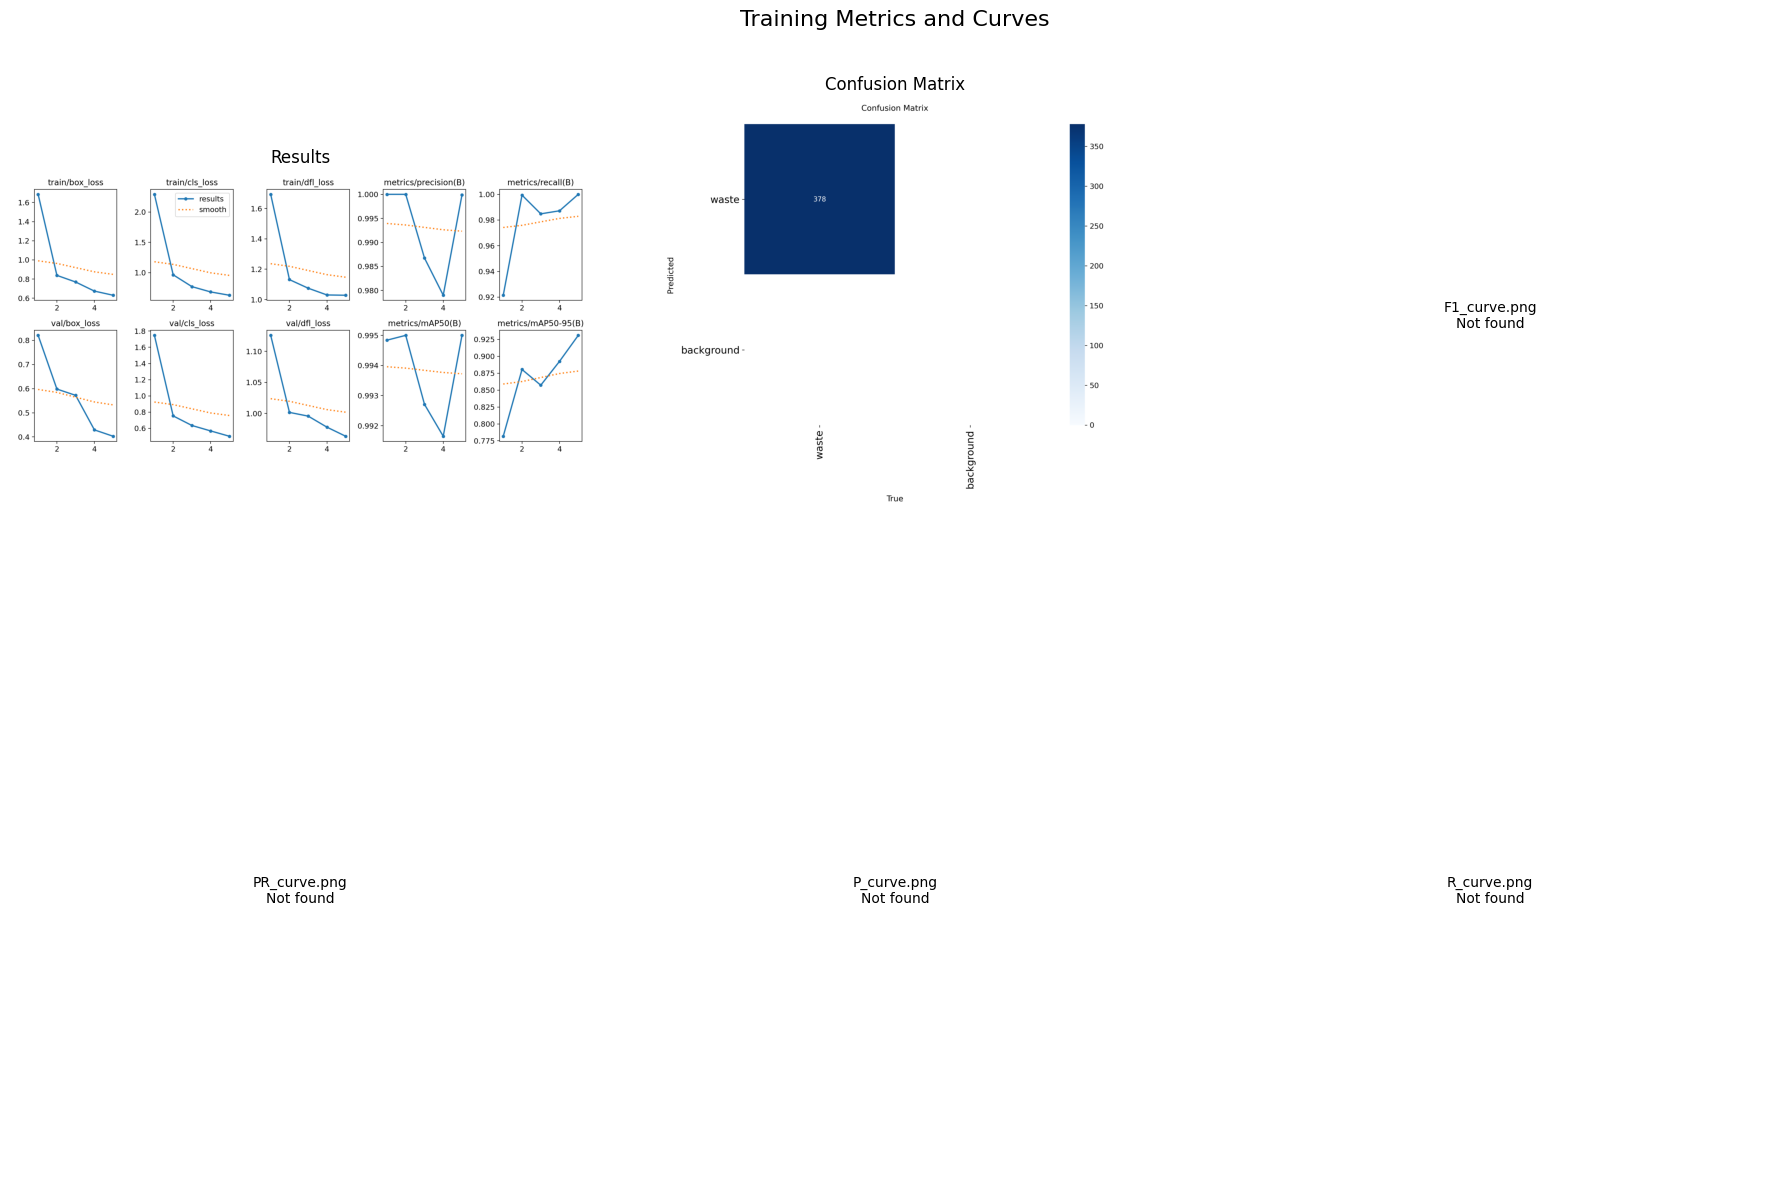

In [15]:
# Display training curves
results_dir = MODELS_PATH / "waste_detector"

# Check for training plots
plot_files = [
    'results.png',
    'confusion_matrix.png',
    'F1_curve.png',
    'PR_curve.png',
    'P_curve.png',
    'R_curve.png'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for ax, plot_file in zip(axes, plot_files):
    plot_path = results_dir / plot_file
    if plot_path.exists():
        img = Image.open(plot_path)
        ax.imshow(img)
        ax.set_title(plot_file.replace('.png', '').replace('_', ' ').title())
    else:
        ax.text(0.5, 0.5, f'{plot_file}\nNot found', ha='center', va='center')
    ax.axis('off')

plt.suptitle('Training Metrics and Curves', fontsize=16)
plt.tight_layout()
plt.show()

## 7. Test Detection on Sample Images

🔍 Running detection on test images...



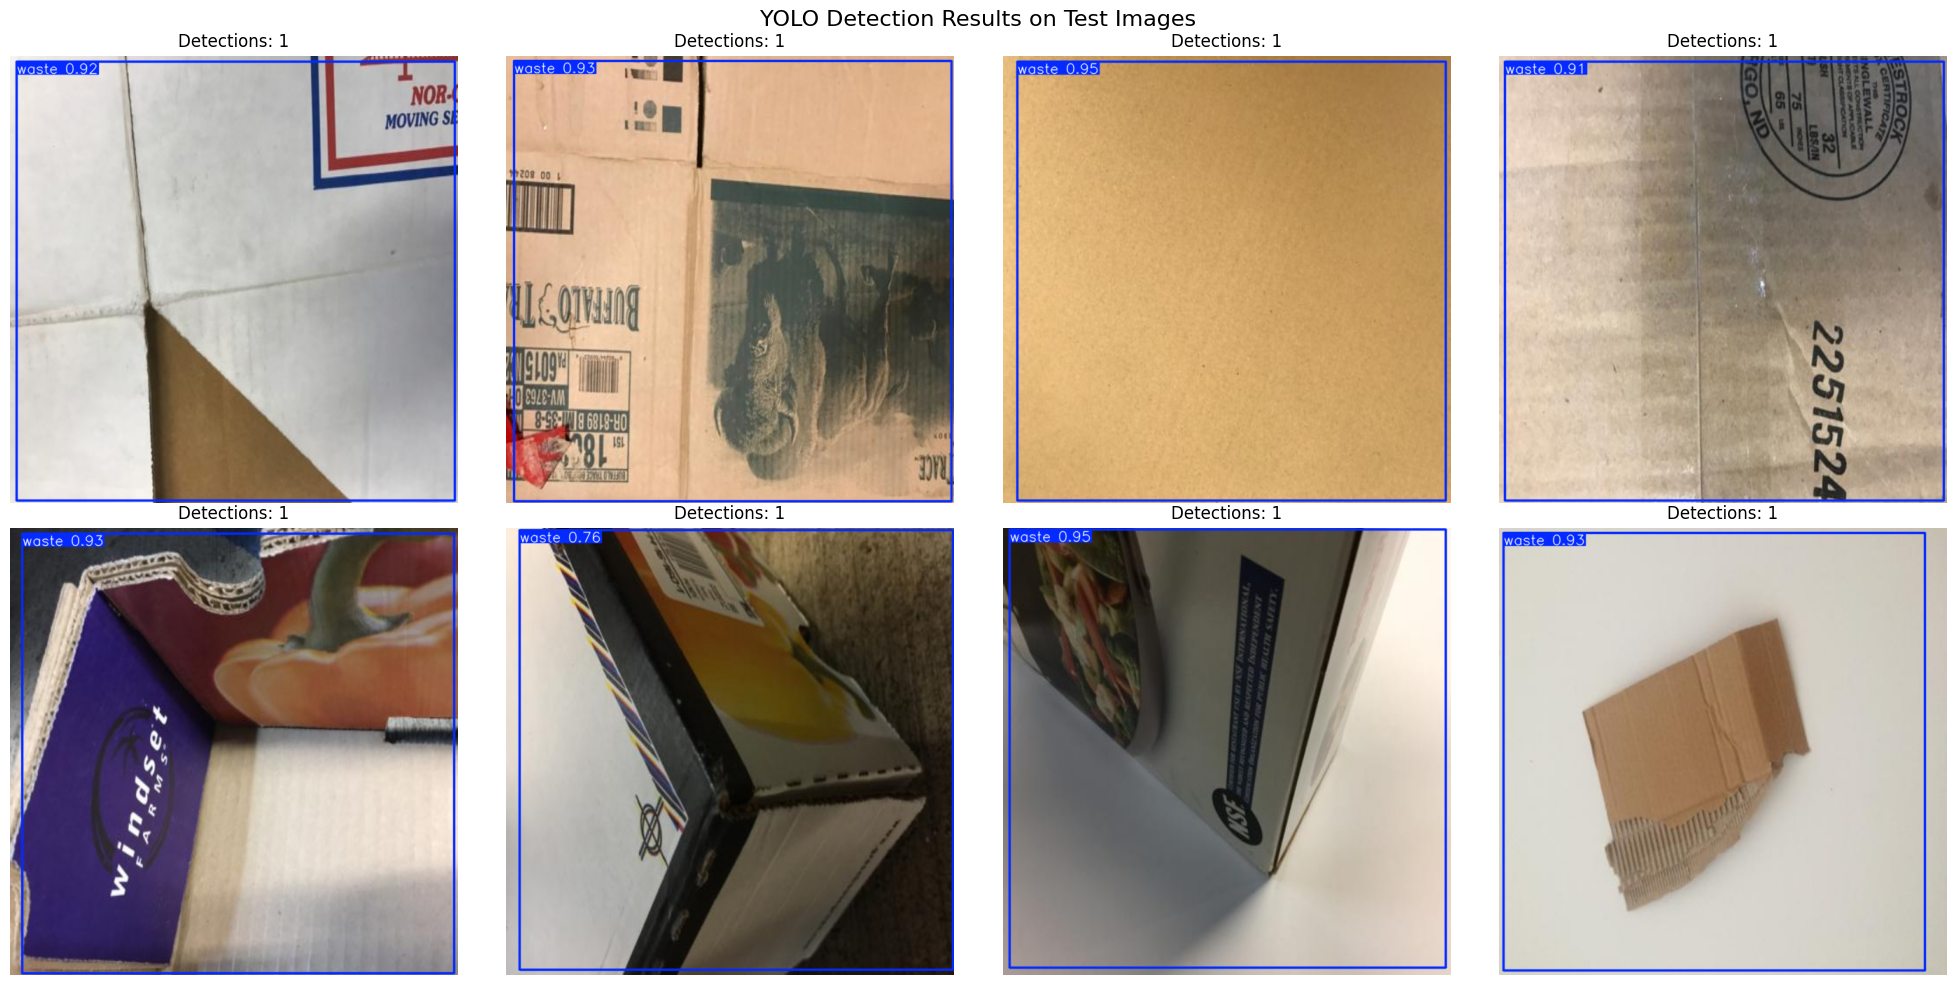

In [16]:
def detect_and_visualize(model, image_path, conf_threshold=0.5):
    """
    Run detection on an image and visualize results.
    """
    # Run inference
    results = model.predict(
        source=str(image_path),
        conf=conf_threshold,
        save=False,
        verbose=False
    )
    
    # Get the result
    result = results[0]
    
    # Get annotated image
    annotated_img = result.plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    
    return annotated_img, result


# Test on validation images
test_images_dir = PROCESSED_DATA_PATH / "test" / "images"
test_images = list(test_images_dir.glob("*.jpg"))[:8]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

print("🔍 Running detection on test images...\n")

for ax, img_path in zip(axes, test_images):
    annotated_img, result = detect_and_visualize(
        trained_model, 
        img_path, 
        conf_threshold=YOLO_CONFIG['confidence_threshold']
    )
    
    ax.imshow(annotated_img)
    ax.axis('off')
    
    # Show detection count
    num_detections = len(result.boxes)
    ax.set_title(f"Detections: {num_detections}")

plt.suptitle('YOLO Detection Results on Test Images', fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
# Detailed detection analysis on a single image
sample_image = test_images[0]

results = trained_model.predict(
    source=str(sample_image),
    conf=YOLO_CONFIG['confidence_threshold'],
    verbose=False
)

result = results[0]

print("📋 Detection Details:")
print("=" * 50)
print(f"Image: {sample_image.name}")
print(f"Number of detections: {len(result.boxes)}")
print("\nBounding Boxes:")

for i, box in enumerate(result.boxes):
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    conf = box.conf[0].item()
    cls = int(box.cls[0].item())
    
    print(f"  Detection {i+1}:")
    print(f"    Class: {result.names[cls]}")
    print(f"    Confidence: {conf:.4f}")
    print(f"    Box: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")

📋 Detection Details:
Image: cardboard_cardboard100.jpg
Number of detections: 1

Bounding Boxes:
  Detection 1:
    Class: waste
    Confidence: 0.9197
    Box: [9.7, 9.3, 635.1, 636.7]


## 8. Save Model and Export

In [18]:
# Copy best model to main models directory
final_model_path = MODELS_PATH / "waste_detector_best.pt"

if best_model_path.exists():
    shutil.copy(best_model_path, final_model_path)
    print(f"✅ Best model saved to: {final_model_path}")
else:
    print("⚠️ Best model weights not found.")

# Also save last model
last_model_path = MODELS_PATH / "waste_detector" / "weights" / "last.pt"
if last_model_path.exists():
    final_last_path = MODELS_PATH / "waste_detector_last.pt"
    shutil.copy(last_model_path, final_last_path)
    print(f"✅ Last model saved to: {final_last_path}")

✅ Best model saved to: c:\Users\anike\Downloads\WasteSegregation\models\yolo\waste_detector_best.pt
✅ Last model saved to: c:\Users\anike\Downloads\WasteSegregation\models\yolo\waste_detector_last.pt


In [19]:
# Export model to ONNX format (optional - for deployment)
print("📦 Exporting model to ONNX format...")

try:
    onnx_path = trained_model.export(format='onnx')
    print(f"✅ ONNX model exported to: {onnx_path}")
except Exception as e:
    print(f"⚠️ ONNX export failed: {e}")
    print("   This is optional and won't affect the project.")

📦 Exporting model to ONNX format...
Ultralytics 8.4.7  Python-3.13.5 torch-2.9.1+cpu CPU (13th Gen Intel Core i7-1355U)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'c:\Users\anike\Downloads\WasteSegregation\models\yolo\waste_detector\weights\best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 5, 1029) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<2.0.0', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   - -------------------------------------- 0.5/16.4 MB 3.1 MB/s eta 0:00:06
   -- ------------------------------------- 1.0/16.4 MB 2.4 MB/s eta 0:00:07
   --- ------------------------------------ 1.3/16.4 MB 2.3 MB/s eta 0:00:07
   ---- ----------------------------------- 1.8/16.4 MB 2.1 MB/s eta 0:00:08
   ----- --------------------------

c:\Users\anike\Downloads\WasteSegregation\.venv\Lib\site-packages\torch\onnx\_internal\torchscript_exporter\utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.82...
ONNX: export success  134.1s, saved as 'c:\Users\anike\Downloads\WasteSegregation\models\yolo\waste_detector\weights\best.onnx' (11.6 MB)

Export complete (134.2s)
Results saved to C:\Users\anike\Downloads\WasteSegregation\models\yolo\waste_detector\weights
Predict:         yolo predict task=detect model=c:\Users\anike\Downloads\WasteSegregation\models\yolo\waste_detector\weights\best.onnx imgsz=224 
Validate:        yolo val task=detect model=c:\Users\anike\Downloads\WasteSegregation\models\yolo\waste_detector\weights\best.onnx imgsz=224 data=c:\Users\anike\Downloads\WasteSegregation\config\dataset.yaml  
Visualize:       https://netron.app
✅ ONNX model exported to: c:\Users\anike\Downloads\WasteSegregation\models\yolo\waste_detector\weights\best.onnx


## 9. Create Detection Utility Function

In [20]:
# Save a utility function for later use
detection_utils_code = '''
"""
YOLO Detection Utilities for Waste Segregation System
"""

import cv2
import numpy as np
from pathlib import Path
from ultralytics import YOLO


class WasteDetector:
    """
    Waste object detector using trained YOLOv8 model.
    """
    
    def __init__(self, model_path, confidence_threshold=0.5, iou_threshold=0.45):
        """
        Initialize the waste detector.
        
        Args:
            model_path: Path to the trained YOLO model weights
            confidence_threshold: Minimum confidence for detections
            iou_threshold: IoU threshold for NMS
        """
        self.model = YOLO(str(model_path))
        self.conf_threshold = confidence_threshold
        self.iou_threshold = iou_threshold
    
    def detect(self, image):
        """
        Detect waste objects in an image.
        
        Args:
            image: Image path or numpy array (BGR format)
            
        Returns:
            List of detections with bounding boxes and confidence scores
        """
        results = self.model.predict(
            source=image,
            conf=self.conf_threshold,
            iou=self.iou_threshold,
            verbose=False
        )
        
        detections = []
        result = results[0]
        
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            conf = box.conf[0].item()
            cls = int(box.cls[0].item())
            
            detections.append({
                \'bbox\': [int(x1), int(y1), int(x2), int(y2)],
                \'confidence\': conf,
                \'class_id\': cls,
                \'class_name\': result.names[cls]
            })
        
        return detections
    
    def detect_and_crop(self, image):
        """
        Detect waste objects and return cropped regions.
        
        Args:
            image: Image path or numpy array
            
        Returns:
            List of tuples: (cropped_image, detection_info)
        """
        if isinstance(image, (str, Path)):
            img = cv2.imread(str(image))
        else:
            img = image.copy()
        
        detections = self.detect(img)
        crops = []
        
        for det in detections:
            x1, y1, x2, y2 = det[\'bbox\']
            cropped = img[y1:y2, x1:x2]
            crops.append((cropped, det))
        
        return crops
    
    def draw_detections(self, image, detections=None):
        """
        Draw bounding boxes on image.
        
        Args:
            image: Image path or numpy array
            detections: Optional list of detections (will detect if not provided)
            
        Returns:
            Annotated image
        """
        if isinstance(image, (str, Path)):
            img = cv2.imread(str(image))
        else:
            img = image.copy()
        
        if detections is None:
            detections = self.detect(img)
        
        for det in detections:
            x1, y1, x2, y2 = det[\'bbox\']
            conf = det[\'confidence\']
            
            # Draw box
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Draw label
            label = f"waste: {conf:.2f}"
            cv2.putText(img, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        return img
'''

# Save the utility module
utils_path = PROJECT_ROOT / "src" / "detector.py"
with open(utils_path, 'w') as f:
    f.write(detection_utils_code.replace("\\'", "'"))

print(f"✅ Detection utilities saved to: {utils_path}")

✅ Detection utilities saved to: c:\Users\anike\Downloads\WasteSegregation\src\detector.py


## 10. Phase 3 Summary

In [21]:
print("=" * 60)
print("🎉 PHASE 3 COMPLETE: YOLO OBJECT DETECTION TRAINING")
print("=" * 60)

print("\n📦 MODEL DETAILS:")
print(f"   • Base Model: YOLOv8 Nano")
print(f"   • Training Epochs: {YOLO_CONFIG['epochs']}")
print(f"   • Image Size: {config['dataset']['yolo_image_size']}x{config['dataset']['yolo_image_size']}")
print(f"   • Classes: 1 (waste)")

print("\n📈 PERFORMANCE METRICS:")
try:
    print(f"   • mAP50: {val_results.box.map50:.4f}")
    print(f"   • mAP50-95: {val_results.box.map:.4f}")
    print(f"   • Precision: {val_results.box.mp:.4f}")
    print(f"   • Recall: {val_results.box.mr:.4f}")
except:
    print("   • Metrics will be available after training")

print("\n📁 SAVED FILES:")
print(f"   • Best Model: {MODELS_PATH / 'waste_detector_best.pt'}")
print(f"   • Training Results: {MODELS_PATH / 'waste_detector'}")
print(f"   • Detector Module: {PROJECT_ROOT / 'src' / 'detector.py'}")

print("\n✅ NEXT STEPS:")
print("   1. Phase 4: Train MobileNet classification model")
print("   2. Phase 5: Train Autoencoder for anomaly detection")
print("   3. Phase 6: Integrate all models into pipeline")

print("\n" + "=" * 60)

🎉 PHASE 3 COMPLETE: YOLO OBJECT DETECTION TRAINING

📦 MODEL DETAILS:
   • Base Model: YOLOv8 Nano
   • Training Epochs: 15
   • Image Size: 320x320
   • Classes: 1 (waste)

📈 PERFORMANCE METRICS:
   • mAP50: 0.9950
   • mAP50-95: 0.9299
   • Precision: 0.9999
   • Recall: 1.0000

📁 SAVED FILES:
   • Best Model: c:\Users\anike\Downloads\WasteSegregation\models\yolo\waste_detector_best.pt
   • Training Results: c:\Users\anike\Downloads\WasteSegregation\models\yolo\waste_detector
   • Detector Module: c:\Users\anike\Downloads\WasteSegregation\src\detector.py

✅ NEXT STEPS:
   1. Phase 4: Train MobileNet classification model
   2. Phase 5: Train Autoencoder for anomaly detection
   3. Phase 6: Integrate all models into pipeline

